In [1]:
# imports and setup
import os
import pandas as pd
import numpy as np

import warnings
import sklearn.linear_model
import sklearn.metrics
import random

from numpy.random import default_rng
from sklearn.datasets import make_classification, load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
np.set_printoptions(suppress=True, precision=3)

#  Function.

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    for i in range(len(ytrue_N)):
        if (ytrue_N[i] == yhat_N[i] == 1):
            TP += 1
        elif (ytrue_N[i] == yhat_N[i] == 0):
            TN += 1
        elif (ytrue_N[i] == 0 and yhat_N[i] == 1):
            FP += 1
        else:
            FN += 1
    return TP, TN, FP, FN

In [3]:
def div_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = list()
    TN = list()
    FP = list()
    FN = list()
    
    for i in range(len(ytrue_N)):
        if (ytrue_N[i] == yhat_N[i] == 1):
            TP.append(i)
        elif (ytrue_N[i] == yhat_N[i] == 0):
            TN.append(i)
        elif (ytrue_N[i] == 0 and yhat_N[i] == 1):
            FP.append(i)
        else:
            FN.append(i)
    return TP, TN, FP, FN

In [4]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [5]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [6]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
    
    A "perfect" classifier would assign everything in class 0 the probability 0.0, 
    and everything in class 1 the probability 1.0, and the histograms would look 
    like one big pile of 150 items at 0.0, and then 25 items at 1.0.  
    
    You can actually see what this would look like by calling:
        make_plot_perf_vs_threshold(y_va_N, y_va_N)
    
    Note that we of course don't expect perfect (0.0/1.0) predictions, but we can 
    still get a "perfect" probabilistic classifier if we have a threshold point T 
    where all the 0-class stuff from the first histogram is below T, and all the 
    1-class stuff from the second one is at or above T.  Of course, we probably 
    can't get that either, since complex data may not be linearly separable at all, 
    but that's the goal.
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

#  Load the dataset.

In [7]:
# Load 3 feature version of x arrays
x_tr = np.loadtxt('./data_digits_8_vs_9_noisy/x_train.csv', delimiter=',', skiprows=1)
x_te = np.loadtxt('./data_digits_8_vs_9_noisy/x_test.csv', delimiter=',', skiprows=1)

y_tr = np.loadtxt('./data_digits_8_vs_9_noisy/y_train.csv', delimiter=',', skiprows=1)
y_te = np.loadtxt('./data_digits_8_vs_9_noisy/y_test.csv', delimiter=',', skiprows=1)

##  Question 1.

In [8]:
tr_loss_list = list()

model_list = list()
acc_list = list()
i_grid = list(range(1, 41)) 

In [9]:
for i in i_grid:
    model = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=i)
    model.fit(x_tr,y_tr)
    
    model_list.append(model)
    pred_tr = model.predict_proba(x_tr)
    
    score = model.score(x_tr,y_tr)
    tr_log_loss = sklearn.metrics.log_loss(y_tr,pred_tr)
    
    # score
    acc_list.append(score)

    # log loss
    tr_loss_list.append(tr_log_loss)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear fai

In [10]:
# tr_loss_list

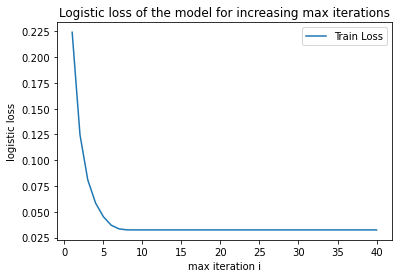

In [11]:
# Log loss plot

plt.xlabel('max iteration i');
plt.ylabel('logistic loss');

sns.lineplot(x = i_grid, y = tr_loss_list, label = "Train Loss")

# show a legend on the plot 
plt.legend() 
plt.title('Logistic loss of the model for increasing max iterations')
plt.show()

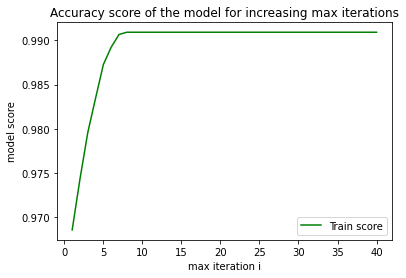

In [12]:
# Accuracy plot

plt.xlabel('max iteration i');
plt.ylabel('model score');

sns.lineplot(x = i_grid, y = acc_list, label = "Train score", color='green')

# show a legend on the plot 
plt.legend() 
plt.title('Accuracy score of the model for increasing max iterations')
plt.show()

#### Discussion:
    discuss the results you are seeing; what do they show, and why?
    
    As the max_iter increases, the accuracy rate increases and the log loss decreases. We see the log loss drastically shooting down and the accuracy rate shooting up during the first 9 iterations. The accuracy rate and log loss stay the same with nine or more iterations.
    
    As suggested by the 9 ConvergenceWarnings, with only 9 iterations, the model fails to converge, which results in high error rate and low accuracy rate. As we increase the number of iterations, the model converges and begins to generate constant error result and accuracy rate.
    

##  Question 2.

In [13]:
coef_list = list()

In [14]:
for i in range(40):
    model_coef = model_list[i].coef_[0][0]
    coef_list.append(model_coef)

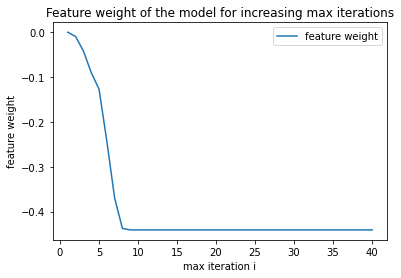

In [15]:
# Coef plot
plt.xlabel('max iteration i');
plt.ylabel('feature weight');

sns.lineplot(x = i_grid, y = coef_list, label = "feature weight")

# show a legend on the plot 
plt.legend() 
plt.title('Feature weight of the model for increasing max iterations')
plt.show()

#### Discussion:
    discuss the results you are seeing; what do they show, and why?
    
    As the max_iter increases, the feature weight decreases. We see the feature weight drastically shooting down during the first 9 iterations, and stays the same with nine or more iterations.
    
    As suggested by the 9 ConvergenceWarnings and corresponds with previous results, with only 9 iterations the model fails to converge, which results in high feature weight. As we increase the number of iterations, the model converges and begins to generate constant feature weight.

##  Question 3.

In [16]:
te_loss_list_w_C = list()

model_list_w_C = list()
acc_list_w_C = list()

In [17]:
C_grid = np.logspace(-9, 6, 31)

for C in C_grid:
    model = sklearn.linear_model.LogisticRegression(C=C,solver='liblinear')
    model.fit(x_tr,y_tr)
   
    model_list_w_C.append(model)
    
    pred_te = model.predict_proba(x_te)
    score_te = model.score(x_te,y_te)
    te_log_loss = sklearn.metrics.log_loss(y_te,pred_te)

    # score
    acc_list_w_C.append(score_te)

    # log loss
    te_loss_list_w_C.append(te_log_loss)

### Data

In [18]:
# print out the results in clear tabular format
# pd.DataFrame(np.transpose([np.log10(C_grid), te_loss_list_w_C, acc_list_w_C]), columns=['C value(log 10 base)', 'logistic loss', 'accuracy rate'])

In [19]:
min_te_loss = min(te_loss_list_w_C)
min_te_loss_index = te_loss_list_w_C.index(min_te_loss)
best_C =  C_grid[min_te_loss_index]
best_acc = acc_list_w_C[min_te_loss_index]

In [20]:
print("Best C-value for LR with 2-feature data: ", best_C) 
print("Test set log-loss at best C-value: %.4f ", min_te_loss)
print("Test set accuracy rate at best C-value: ", best_acc)

Best C-value for LR with 2-feature data:  0.03162277660168379
Test set log-loss at best C-value: %.4f  0.08968955614249495
Test set accuracy rate at best C-value:  0.9672213817448311


### Confusion Matrix

In [21]:
best_model = model_list_w_C[min_te_loss_index]
ypred_te = best_model.predict_proba(x_te)
print(calc_confusion_matrix_for_threshold(y_te, ypred_te[:, 1], 0.5))

Predicted    0    1
True               
0          942   32
1           33  976


#### Discussion:
    The best C value is at 0.032, with the log loss of 0.0897 and an accuracy rate of 0.9672.

##  Question 4.

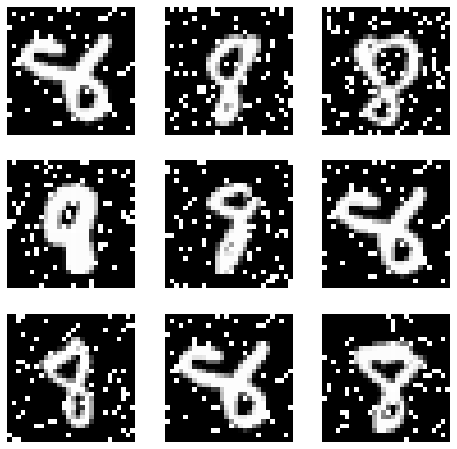

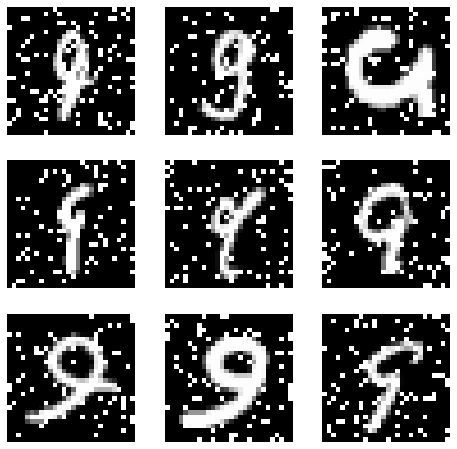

In [22]:
ypredict_te = best_model.predict(x_te)
TP_i, TN_i, FP_i, FN_i = div_TP_TN_FP_FN(y_te, ypredict_te)

# _, FP_arr = plt.subplots(3,3)
# _, FN_arr = plt.subplots(3,3)

rng = default_rng()
FP_indices = rng.choice(FP_i, 9)
FN_indices = rng.choice(FN_i, 9)

random_data = x_te[FP_indices]
random_data2 = x_te[FN_indices]


# FP_arr[i, j].imshow(np.reshape(x_te[FP_indices[(i*3 + j)]], (28,28)), cmap=plt.cm.gray,vmin=0.0, vmax=1.0)
# # Here are 5 such random data points, reshaped and displayed as images


# grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)
# fig1 = plt.subplot(grid[0, 0])
# fig1 = plt.subplot(grid[0, 1])

fig1 = plt.figure(figsize=(8, 8))
for index, img in enumerate(random_data):
    plt.subplot(3, 3, index + 1)
    plt.axis('off')
    plt.imshow(np.reshape(img, (28,28)), cmap=plt.cm.gray, vmin=0.0, vmax=1.0)
    

fig2 = plt.figure(figsize=(8, 8))
for j, img2 in enumerate(random_data2):
    plt.subplot(3, 3, j + 1)
    plt.axis('off')
    plt.imshow(np.reshape(img2, (28,28)), cmap=plt.cm.gray,vmin=0.0, vmax=1.0)
    
plt.show()
    

TP - true [0. 0. 0. 0. 0. 0. 0. 0. 0.]
TP - pred [1. 1. 1. 1. 1. 1. 1. 1. 1.]
TN - true [1. 1. 1. 1. 1. 1. 1. 1. 1.]
TN - pred [0. 0. 0. 0. 0. 0. 0. 0. 0.]


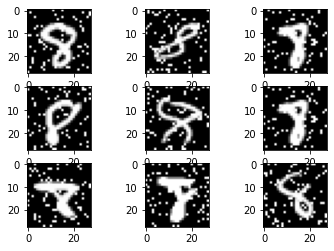

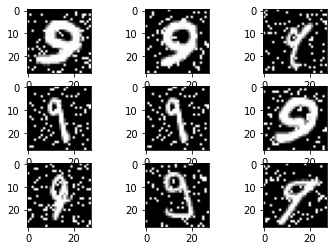

In [23]:
ypredict_te = best_model.predict(x_te)
TP_i, TN_i, FP_i, FN_i = div_TP_TN_FP_FN(y_te, ypredict_te)

_, FP_arr = plt.subplots(3,3)
_, FN_arr = plt.subplots(3,3)

FP_indices = rng.choice(FP_i, 9)
FN_indices = rng.choice(FN_i, 9)


# Here are 5 such random data points, reshaped and displayed as images
# plt.figure(figsize=(20, 3))
# for index, (img, out) in enumerate(zip(random_data, random_data_labels)):
#     plt.subplot(1, 5, index + 1)
#     plt.imshow(np.reshape(img, (8,8)), cmap=plt.cm.gray)

#     plt.title('Label = %i\n' % out, fontsize=20)
    
    
# FP_arr.set_xticks([])
# FP_arr.set_yticks([])

print('TP - true', y_te[FP_indices])
print('TP - pred', ypredict_te[FP_indices])

print('TN - true', y_te[FN_indices])
print('TN - pred', ypredict_te[FN_indices])


# np.reshape(x_te[indices[0]], (28,28))
for i in range(3):
    for j in range(3):
        FP_arr[i, j].imshow(np.reshape(x_te[FP_indices[(i*3 + j)]], (28,28)), cmap=plt.cm.gray,vmin=0.0, vmax=1.0)
        FN_arr[i, j].imshow(np.reshape(x_te[FN_indices[(i*3 + j)]], (28,28)), cmap=plt.cm.gray,vmin=0.0, vmax=1.0)

plt.show()

#### Discussion:
    For all false negative examples, the circle on the bottom were either overlapped so that it was no longer perceived as a loop. Therefore, although they are in class 0 (digit 8), they are predicted as 9. 
    
    Similarly, for all false positive examples, the tail is bented on the bottom, just like how we would normally write a 8. Therefore, although they are in class 1 (digit 9), they are predicted as 8. 

##  Question 5.

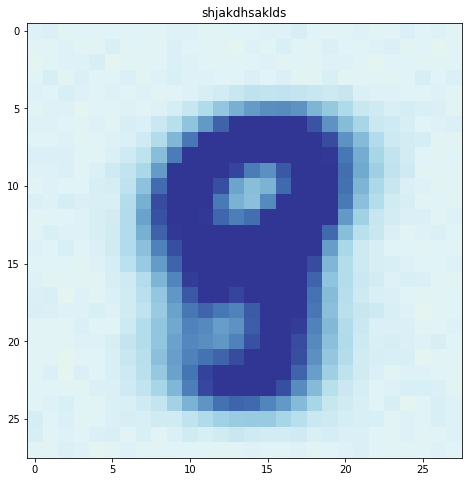

In [24]:
aver = np.mean(x_te,axis=0)

plt.figure(figsize=(8, 8),frameon = True)
for index in range(len(x_te)):
    plt.imshow(np.reshape(aver, (28,28)), cmap=plt.cm.RdYlBu,vmin=-0.5, vmax=0.5)
    
plt.title('shjakdhsaklds', loc='center')

plt.show()
    

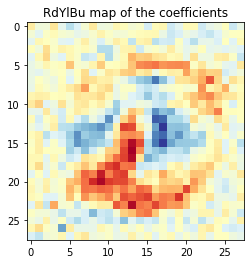

In [25]:
plt.imshow(best_model.coef_[0].reshape(28,28), cmap='RdYlBu',vmin=-0.5, vmax=0.5)
plt.title('RdYlBu map of the coefficients', loc='center')
plt.show()

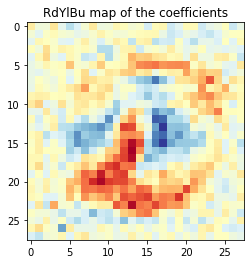

In [26]:
plt.imshow(best_model.coef_[0].reshape(28,28), cmap=plt.cm.RdYlBu ,vmin=-0.5, vmax=0.5)
plt.title('RdYlBu map of the coefficients', loc='center')
plt.show()

#### Discussion:
    Below it, discuss what it shows. Which pixels correspond to an 8 (have negative weights), and which correspond to a 9 (have positive weights)? Why do you think this is the case?
    
    The pixels from 7-20 on x-axis and 5-25 on y-axis, excluding the lower left hald correspond to 9, and entire area of the pixels from 7-20 on x-axis and 5-25 on y-axis correspond to 8. If we do the subtraction, the pixels in the area of 5-10 in x-axis and 17-25 on y-axis(lower left half) correspond to 8 will do a good job to distinguish 8 and 9. THis is because when we compare how people normally write 8 and 9, 8 has the left lower half of the curly circle while 9 does not. 